<a href="https://www.kaggle.com/code/stutiiikatariaaa/randomforest?scriptVersionId=270016607" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/kaggle/input/solargeneration/dataset.csv')
df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M')

In [2]:
# Feature engineering
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek

# Select features and target
features = ['temperature', 'Ground_radiation_intensity ', 'hour']
X = df[features]
y = df['Photovoltaic_power_generation']

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor


# Split data (time-series split)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only (avoid data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler

# Convert back to DataFrame for readability
X_train = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

Random Forest Regressor without hyperparameter tuning


Default Random Forest Test Set Evaluation:
MSE: 213072.62
RMSE: 461.60
MAE: 265.04
R² Score: 0.83


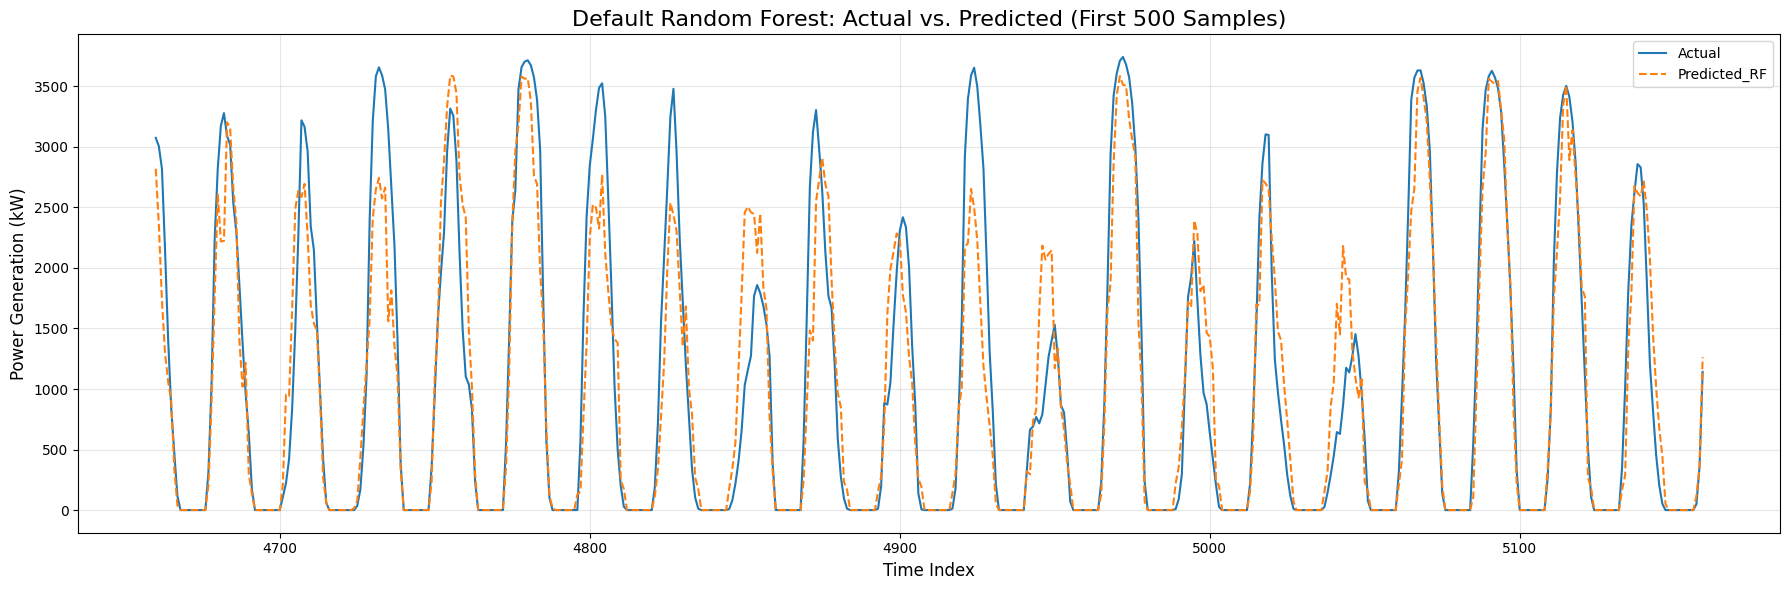

In [4]:
# Initialize Random Forest Regressor with fixed/default parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)

# Fit on training data
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)

# Evaluate predictions
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\nDefault Random Forest Test Set Evaluation:")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

# Visualization
results_rf = pd.DataFrame({
    'Actual': y_test,
    'Predicted_RF': y_pred_rf
}, index=y_test.index)

plt.figure(figsize=(18, 6))
results_rf.head(500).plot(style=['-', '--'], ax=plt.gca())
plt.title("Default Random Forest: Actual vs. Predicted (First 500 Samples)", fontsize=16)
plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Power Generation (kW)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Random Forest Regressor with hyperparameter tuning

In [5]:
from sklearn.model_selection import GridSearchCV
# Define parameter grid for Random Forest tuning
param_grid_rf = {
    'n_estimators': [50, 150, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4]
}
# Setup GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=10, scoring='r2', n_jobs=-1, verbose=0)

# Fit on training data
grid_search_rf.fit(X_train, y_train)

# Best estimator and parameters
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_

# Predict on test set using best model
y_pred_rf = best_rf.predict(X_test)
# Evaluate predictions
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"\nTuned Random Forest Test Set Evaluation:")
print(f"MSE: {mse_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

cv_rf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_r2_rf_scores = cross_val_score(best_rf, X_train, y_train, cv=cv_rf, scoring='r2')

print("\n📉 Cross-Validation R² Scores on Training Data:")
for i, score in enumerate(cv_r2_rf_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"\n✅ Mean CV R²: {cv_r2_rf_scores.mean():.4f} ± {cv_r2_rf_scores.std():.4f}")



Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

Tuned Random Forest Test Set Evaluation:
MSE: 193514.82
RMSE: 439.90
MAE: 253.91
R² Score: 0.85

📉 Cross-Validation R² Scores on Training Data:
Fold 1: 0.8930
Fold 2: 0.8805
Fold 3: 0.8951
Fold 4: 0.8486
Fold 5: 0.9056
Fold 6: 0.8838
Fold 7: 0.8668
Fold 8: 0.8450
Fold 9: 0.8465
Fold 10: 0.8572

✅ Mean CV R²: 0.8722 ± 0.0212


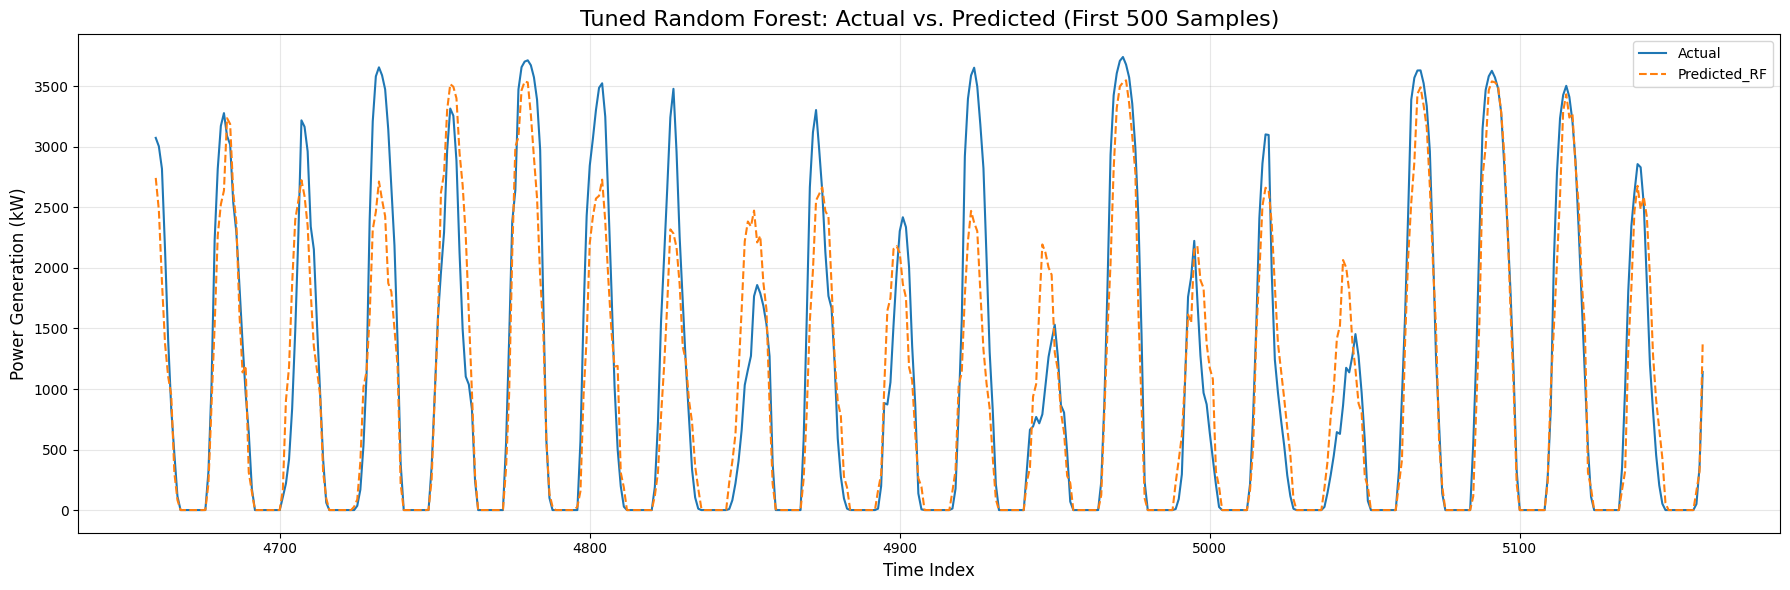

In [6]:
# Visualization
import matplotlib.pyplot as plt
results_rf = pd.DataFrame({
    'Actual': y_test,
    'Predicted_RF': y_pred_rf
}, index=y_test.index)
plt.figure(figsize=(18, 6))
results_rf.head(500).plot(style=['-', '--'], ax=plt.gca())
plt.title("Tuned Random Forest: Actual vs. Predicted (First 500 Samples)", fontsize=16)
plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Power Generation (kW)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()